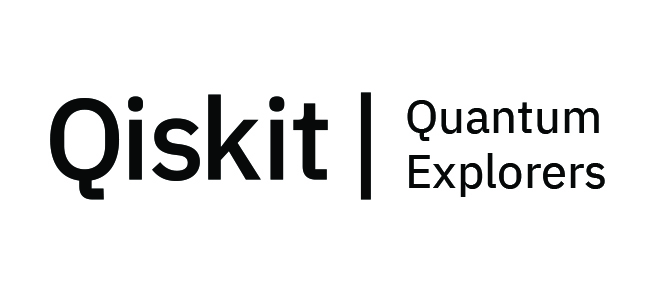

# Traveling Salesman Problem
A demo for Quantum Explorers Expert Navigator Badge Learning Module

Code taken from [Qiskit Tutorial: Max-Cut and Traveling Salesman Problem](https://github.com/Qiskit/qiskit-optimization/blob/stable/0.4/docs/tutorials/06_examples_max_cut_and_tsp.ipynb)

### Application classes

We use the application classes fo the traveling salesman problem. There are application classes for other optimization problems available as well.
See [Application Classes for Optimization Problems](09_application_classes.ipynb) for details.

### Application Classes for Optimization Problems
1. Exact cover problem
2. Knapsack problem
3. Number partition problem
4. Set packing problem
5. Clique problem
6. Graph partition problem
7. Max-cut problem
8. Stable set problem
9. Traveling salesman problem
10. Vehicle routing problem
11. Vertex cover problem

### Import necessary libraries and packages

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Traveling Salesman Problem

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$).  The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

with the following constraints where any given node can be visited only once. 

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$



Combining this all together, we get a single objective function to be minimized:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that $A$ is large enough so that these constraints are respected. One way to do this is to choose $A$ such that $A > \mathrm{max}(w_{ij})$.

One of our goals is to map this form to an Ising Hamiltonian, so that the solution can be obtained by finding the mimimum eigen value of the hamiltonian.

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


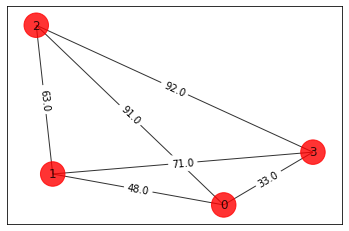

In [3]:
# Let us first generate a graph with 4 nodes
n =4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Brute force approach

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


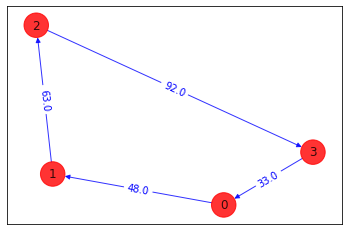

In [4]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


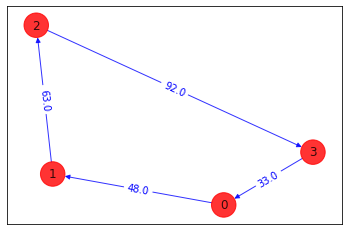

In [5]:
best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

draw_tsp_solution(tsp.graph, best_order, colors, pos)

# Examine the quantum approach
## 1. Call Application Class TSP and create a Quadratic Program instance

In [6]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

## 2. Convert the quadratic program to QUBO

In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 51756.0
Ising Hamiltonian:
-6456.0 * IIIIIIIIIIIIIIIZ
- 6456.0 * IIIIIIIIIIIIIIZI
- 6456.0 * IIIIIIIIIIIIIZII
- 6456.0 * IIIIIIIIIIIIZIII
- 6461.0 * IIIIIIIIIIIZIIII
- 6461.0 * IIIIIIIIIIZIIIII
- 6461.0 * IIIIIIIIIZIIIIII
- 6461.0 * IIIIIIIIZIIIIIII
- 6493.0 * IIIIIIIZIIIIIIII
- 6493.0 * IIIIIIZIIIIIIIII
- 6493.0 * IIIIIZIIIIIIIIII
- 6493.0 * IIIIZIIIIIIIIIII
- 6468.0 * IIIZIIIIIIIIIIII
- 6468.0 * IIZIIIIIIIIIIIII
- 6468.0 * IZIIIIIIIIIIIIII
- 6468.0 * ZIIIIIIIIIIIIIII
+ 1592.5 * IIIIIIIIIIIIIIZZ
+ 1592.5 * IIIIIIIIIIIIIZIZ
+ 1592.5 * IIIIIIIIIIIIIZZI
+ 1592.5 * IIIIIIIIIIIIZIIZ
+ 1592.5 * IIIIIIIIIIIIZIZI
+ 1592.5 * IIIIIIIIIIIIZZII
+ 1592.5 * IIIIIIIIIIIZIIIZ
+ 12.0 * IIIIIIIIIIIZIIZI
+ 12.0 * IIIIIIIIIIIZZIII
+ 12.0 * IIIIIIIIIIZIIIIZ
+ 1592.5 * IIIIIIIIIIZIIIZI
+ 12.0 * IIIIIIIIIIZIIZII
+ 1592.5 * IIIIIIIIIIZZIIII
+ 12.0 * IIIIIIIIIZIIIIZI
+ 1592.5 * IIIIIIIIIZIIIZII
+ 12.0 * IIIIIIIIIZIIZIII
+ 1592.5 * IIIIIIIIIZIZIIII
+ 1592.5 * IIIIIIIIIZZIIIII
+ 12.0 * IIIIIIIIZIIIIIIZ


### Using NumPyMinimumEigensolver to obtain the lowest eigenvalue

energy: -51520.0
tsp objective: 236.0
feasible: True
solution: [1, 2, 3, 0]
solution objective: 236.0


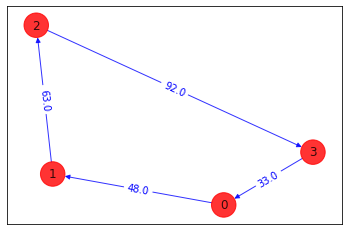

In [8]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

## 3. Run it on quantum computer
Here we first specify the backend we will be running. 

### Create the quantum instance

In [9]:
### algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

### Obtain the minimum eigenvalue using VQE
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [11]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

objective function value: 258.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=1.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
solution: [1, 2, 3, 0]
solution objective: 236.0


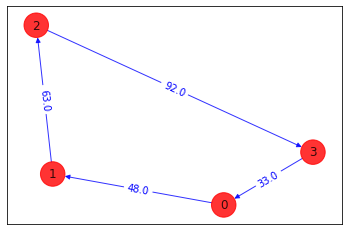

In [12]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)